# DSCI 100 Group Project

### Introduction
To do: 
- Write a bit about what the data set is (couple sentences about PLAICraft, purpose of the study)
- State the question: demand forecasting
- Describe the dataset used: sessions AND players

New question: predicting subscription status
- Use quantitative variables (ignore experience)
- Can use age, hours played, number of sessions, and session length: the last two use some more interesting wrangling techniques to figure out that can show our knowledge and make our investigation a bit different
- Call it "playing behaviour"?

Can a player's age, played hours, average session duration, and number of sessions played predict whether they will subscribe to a game-related newsletter?

PLAICraft is a research group from the Computer Science department at UBC. They have a goal to build an advanced AI that reacts just like a human in a virtual real world setting like Minecraft. To do this, the techniques players use to play the game is used to help build the AI model. While they gather information about the players techniques, PLAICraft also collects player's information. 

### Summary
Upon inspection, the `players` dataset, in which each observation is a unique player, contains the following variables:
- `experience`, the self-reported experience level of each player: character string (should be categorical)
- `subscribe`, whether the player subscribed to a newsletter: logical
- `hashedEmail`, a unique, untraceable identifier derived from the player's email: character string
- `played_hours`, how long they played PLAICraft, in hours: numeric 
- `gender`, their self-reported gender identity: character string
- `Age`, their self-reported age in years: numeric

Data for 196 unique players is included in this dataset.

`sessions`, in which each observation is a play session contains:
- `hashedEmail` of the player who played the session
- `start_time` and `end_time`, timestamps for the beginning and end of the play session: character strings that should be date-times
- `original_start_time` and `original_end_time`, roughly the number of milliseconds between January 1, 1970, and the beginning/end of the play session: numeric

Data for 1535 play sessions is included in this dataset.

### Exploratory Data Analysis

To do: 
- Split the data into a training set and a testing set. Only explore the training set.
- Calculate basic summary statistics on time played and make a few visualizations, like in planning document

Initially, we had expected to find that players who had played more hours and are younger in age are more likely to have subscribed to the game. 

In [1]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
sessions_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/sessions.csv"
players_url <- "https://raw.githubusercontent.com/YoyoLiu314/group-project/refs/heads/main/players.csv"

players <- read_csv(players_url) |>
    clean_names() 
    

sessions <- read_csv(sessions_url) |>
    clean_names() |>   
    select(-starts_with("original")) |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time))
    


sessions
players


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashed_email,start_time,end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00
⋮,⋮,⋮
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-10 23:01:00,2024-05-10 23:07:00
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,2024-07-01 04:08:00,2024-07-01 04:19:00
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [3]:
durations <- sessions |>
    mutate(duration = end_time - start_time) |>
    group_by(hashed_email) |>
    summarize(mean = mean(duration, na.rm = TRUE), play_time = sum(duration, na.rm = TRUE), num_sessions = n())
durations

hashed_email,mean,play_time,num_sessions
<chr>,<drtn>,<drtn>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53.00000 mins,106 mins,2
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30.00000 mins,30 mins,1
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11.00000 mins,11 mins,1
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,32.15385 mins,418 mins,13
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,35.00000 mins,70 mins,2
⋮,⋮,⋮,⋮
fc0224c81384770e93ca717f32713960144bf0b52ff67639433a5c06a653a882,16.00000 mins,16 mins,1
fcab03c6d3079521e7f9665caed0f31fe3dae6b5ccb86e6cb58747a43aa8789f,80.00000 mins,80 mins,1
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774 mins,4795 mins,310


In [4]:
players_joined <- left_join(players, durations) |>
    select(-hashed_email) |>
    mutate(play_time = as.numeric(play_time), mean = as.numeric(mean)) |>
    mutate(play_time = replace_na(play_time, 0), mean = replace_na(mean, 0), num_sessions = replace_na(num_sessions, 0))
players_joined

Joining with `by = join_by(hashed_email)`


experience,subscribe,played_hours,name,gender,age,mean,play_time,num_sessions
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>
Pro,TRUE,30.3,Morgan,Male,9,74.77778,2019,27
Veteran,TRUE,3.8,Christian,Male,17,85.00000,255,3
Veteran,FALSE,0.0,Blake,Male,17,5.00000,5,1
Amateur,TRUE,0.7,Flora,Female,21,50.00000,50,1
Regular,TRUE,0.1,Kylie,Male,21,9.00000,9,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,0.0,Bailey,Female,17,0.00000,0,0
Veteran,FALSE,0.3,Pascal,Male,22,21.00000,21,1
Amateur,FALSE,0.0,Dylan,Prefer not to say,17,5.00000,5,1


In [5]:
players_numeric <- players_joined |>
    mutate(exp_num = case_when(experience == "Beginner" ~ 0, 
                               experience == "Amateur" ~ 1, 
                               experience == "Regular" ~ 2, 
                               experience == "Pro" ~ 3, 
                               experience == "Veteran" ~ 4)) |>
    select(subscribe, age, mean, play_time, exp_num, num_sessions) |>
    mutate(subscribe = as_factor(subscribe))
players_numeric

subscribe,age,mean,play_time,exp_num,num_sessions
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
TRUE,9,74.77778,2019,3,27
TRUE,17,85.00000,255,4,3
FALSE,17,5.00000,5,4,1
TRUE,21,50.00000,50,1,1
TRUE,21,9.00000,9,2,1
⋮,⋮,⋮,⋮,⋮,⋮
TRUE,17,0.00000,0,1,0
FALSE,22,21.00000,21,4,1
FALSE,17,5.00000,5,1,1


## Wrangling complete

Split the data, make some basic visualizations to look at these variables (maybe make some scatter plots coloured by subscription status?) and see if there are any visual relationships

Note that the most interesting variables we have are `mean` and `num_sessions`, which represents how often and for how long the players play instead of just how long they played in total. Pretty much no one else is looking at this, so lean into how important/interesting it is to be examining this.

`exp_num` is just the experience levels recoded into numbers. We can treat it as a numeric variable now for our model.

### Justification

We deliberately chose to visualize `mean` and `num_sessions` because they offer information about each players' behavioural depth. Rather than solely focusing on the total play time, we will be able to look at the players' consistency (how many times they log in to play) and their engagement per session (how long they stay when playing). Visualizing these variables highlight user patterns and provide a better prediction of long-term interest and possibly subscription behaviour. 

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


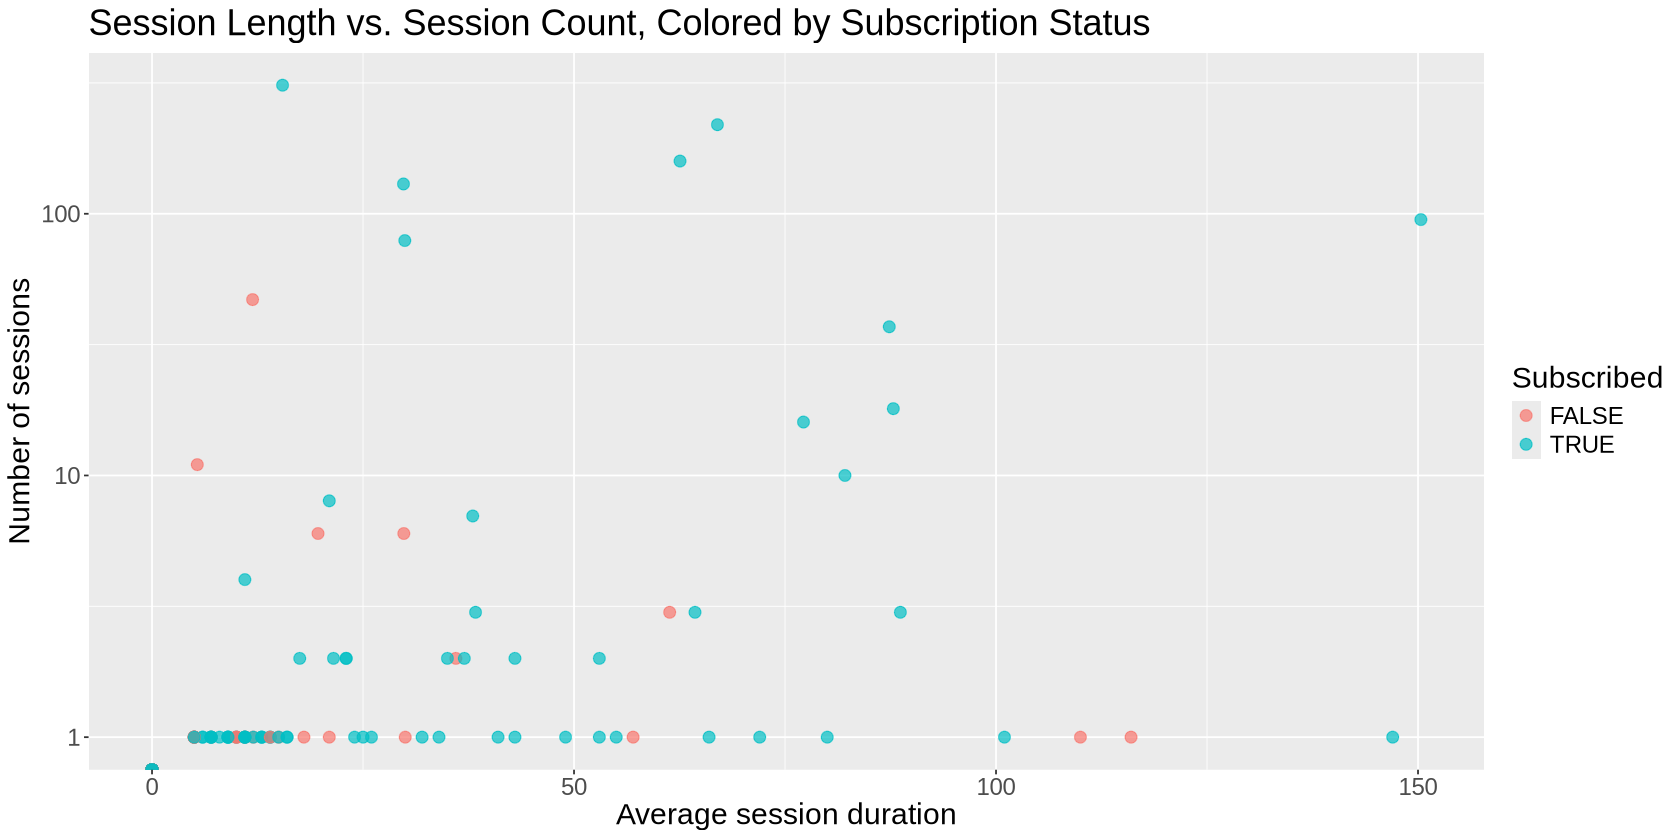

In [6]:
set.seed(1019)
# Split the data 
split <- initial_split(players_numeric, prop = 0.75)
play_train <- training(split)
play_test <- testing(split)

# Scatter plot for visualization (mean vs. num_sessions)
options(repr.plot.width = 14, repr.plot.height = 7)
length_count_plot <- ggplot(play_train, aes(x = mean, y = num_sessions, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    labs(
        title = "Session Length vs. Session Count, Colored by Subscription Status",
        x = "Average session duration",
        y = "Number of sessions",
        color = "Subscribed"
        ) +
    scale_y_log10() +
    theme(text = element_text(size = 18))
length_count_plot

### Visual observations
Observing the scatter plot:
1. Most players are clustered near the bottom-left, indicating they play brief sessions and rarely. Many of the players are not subscribed to game-related newsletters, but there are some subscribers present.
2. Players with high average durations or very high session counts are mostly all subscribers. Indicated on the plot, the top-right region and outlier regions (long and frequent players) are mostly blue, categorizing them as subscribers. This could indicate a behavioural link that deeply engaged game players are subscribed.

We then chose to explore whether gaming experience level would have an effect on subscription given the players' behavioural patterns (how long vs. how often gamers play). Thus, now we ask the question "Does experience level influence how players behave and whether they subscribe?". This is important as experience could moderate behaviour. 

In [8]:
# Second visualization taking into account experience level
options(repr.plot.width = 14, repr.plot.height = 7)
visualization_2 <- ggplot(train_data, aes(x = exp_num, y = num_sessions, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    labs(
        title = "Session Count vs. Experience Level, Coloured by Subscription Status",
        x = "Experience Level",
        y = "Number of sessions",
        color = "Subscribed"
        ) +
    scale_y_log10()
visualization_2

ERROR: Error in eval(expr, envir, enclos): object 'train_data' not found


### Visual Observation
1. All experience levels are present in low-engagement zones at the bottom-left of the scatter plot. Players with few sessions and short durations exist at all experience levels, with many of them being non-subscribers.
2. High engagement users at the top-right are mostly subscribers.
3. Higher experience levels do not guarantee higher engagement. For example, there were still level 4 players who played little with no subscription. Instead, some level 1 and 2 players are among the most engaged and are subscribers.

With this, we can conclude that experience is not strongly correlated with engagement with the game. Overall, average session duration (`mean`) and number of sessions (`num_sessions`) are the strongest predictors of whether players are subscribed or not as the visualizations show a gradient from non-subscriber to subscriber. Experience level (`exp_num`) does not dominate behaviour or subscription, meaning it may interact with other variables but ultimately is not predictive on its own. This suggests how engagement patters drive subscription behaviour.

## Modelling

In [9]:
class_counts <- play_train |>
    group_by(subscribe) |>
    summarize(count = n())
class_counts
40/147
107/147

subscribe,count
<fct>,<int>
FALSE,40
TRUE,107


[1] 0.2721088

[1] 0.7278912



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 28 rows.
               ✖ Assigned data has 29 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 29 to size 28.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





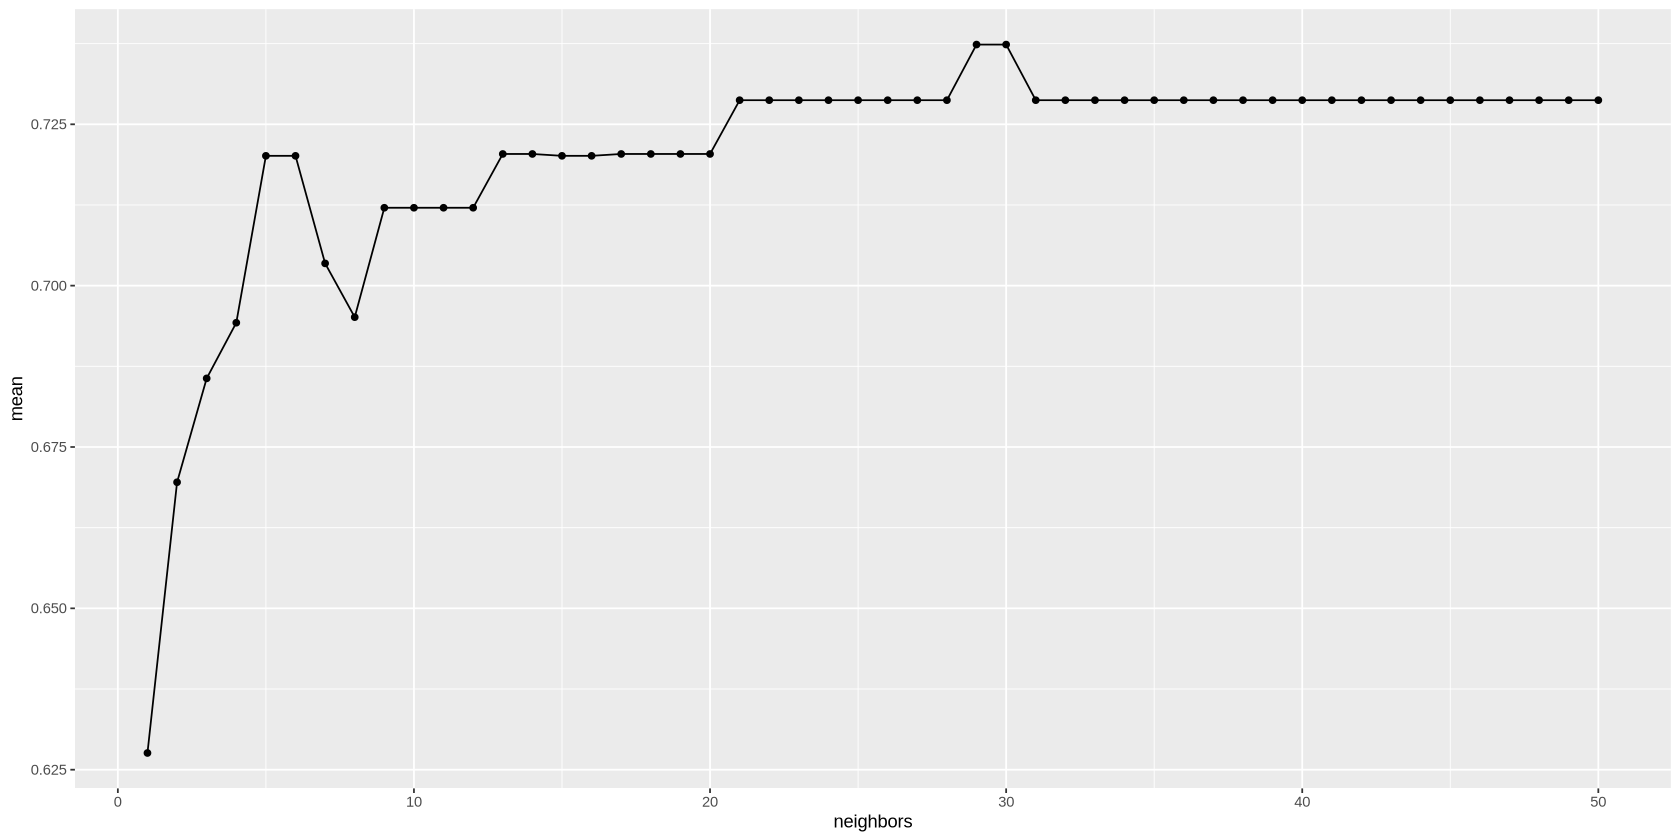

In [10]:
set.seed(1019)
play_recipe <- recipe(subscribe ~ ., data = play_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
play_recipe
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

play_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
play_vfold <- vfold_cv(play_train, v = 5, strata = subscribe)

play_metrics <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(play_spec) |>
    tune_grid(resamples = play_vfold, grid = k_vals) |>
    collect_metrics()

play_plot <- play_metrics |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

play_plot


In [11]:
best_k <- play_metrics |>
    arrange(-mean) 
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,accuracy,binary,0.7373563,4,0.007412085,Preprocessor1_Model29
30,accuracy,binary,0.7373563,4,0.007412085,Preprocessor1_Model30
21,accuracy,binary,0.7287356,4,0.002654484,Preprocessor1_Model21
22,accuracy,binary,0.7287356,4,0.002654484,Preprocessor1_Model22
23,accuracy,binary,0.7287356,4,0.002654484,Preprocessor1_Model23
⋮,⋮,⋮,⋮,⋮,⋮,⋮
41,roc_auc,binary,0.4203869,4,0.09127241,Preprocessor1_Model41
38,roc_auc,binary,0.4184253,4,0.07752428,Preprocessor1_Model38
34,roc_auc,binary,0.4167681,4,0.08546107,Preprocessor1_Model34


From the table above, the best k value to choose is 29. 

In [18]:

final_k_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 29) |>
      set_engine("kknn") |>
      set_mode("classification")

final_play_workflow <- workflow() |>
    add_recipe(play_recipe) |>
    add_model(final_k_spec) 

final_play_fit <- final_play_workflow|>
    fit(data=play_train)

play_test_predictions <- predict(final_play_fit, new_data = play_test)|>
    bind_cols(play_test)

play_test_predictions 

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 48) to match `..2` (size 49).
